In [1]:
import pandas as pds
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from collections import Counter
# for cross validation
from sklearn.model_selection import StratifiedKFold #cross-validation splitter
from sklearn.model_selection import cross_validate #cross-validation evaluation of metrics
# for visualising cross validation
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch
# for KNN
from sklearn.neighbors import KNeighborsClassifier
# for grid search
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
# for plotting ROC score
from sklearn.metrics import RocCurveDisplay
# for cross validation
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
# for random tree
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
# for copy
import copy
# for knn visualisation
from matplotlib.colors import ListedColormap

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pds.read_csv('titanic/train.csv', sep=",")
X = df.copy()
del X["PassengerId"]
del X["Name"]
del X["Ticket"]
del X["Cabin"] # trop peu de passagers ont renseigné leur cabine, on se doit de supprimer la colonne
del X["Embarked"]

In [3]:
def transform_sex_to_int(X):
    gender=[]
    for element in X['Sex']:
        if element == 'male':
            gender.append(0)
        elif element == "female":
            gender.append(1)
        else:
            gender.append(float('nan'))
            
    X["Sex"]=gender
    return
transform_sex_to_int(X)

In [4]:
X=X.dropna()
y=X["Survived"]
del X["Survived"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)

<AxesSubplot:>

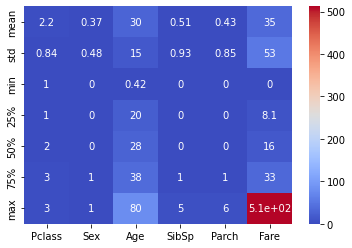

In [5]:
stats = X.describe()
stats = stats.drop('count',axis=0)
sns.heatmap(stats,annot=True,cmap='coolwarm')

In [6]:
zscore = StandardScaler().fit(X)
X_z = pds.DataFrame(zscore.transform(X), index=X.index, columns=X.columns)

<AxesSubplot:>

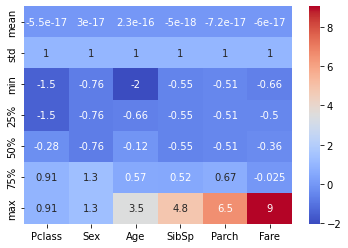

In [7]:
stats = X_z.describe()
stats = stats.drop('count',axis=0)
sns.heatmap(stats,annot=True,cmap='coolwarm')

In [8]:
X_train_z, X_test_z, y_train_z, y_test_z = train_test_split(X_z, y, test_size=0.15, random_state=0)
n_splits=50

In [9]:
param_grid = {
    "n_neighbors":[1,2,3,4,5,6,7,8,9,10,15,20],
    "weights":["uniform", "distance"],
    "algorithm":["auto", "ball_tree", "kd_tree", "brute"],
    "p": [1,2,3],
    "metric" :["euclidean","manhattan"]
}

knn = KNeighborsClassifier()
grid_cv = GridSearchCV(knn, param_grid, scoring="roc_auc", n_jobs=-1, cv=n_splits).fit(X_train_z, y_train_z)

print("Param for GS", grid_cv.best_params_)
print("CV score for GS", grid_cv.best_score_)
print("Train AUC ROC Score for GS: ", roc_auc_score(y_train, grid_cv.predict(X_train)))
print("Test AUC ROC Score for GS: ", roc_auc_score(y_test, grid_cv.predict(X_test)))

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Param for GS {'algorithm': 'ball_tree', 'metric': 'manhattan', 'n_neighbors': 10, 'p': 1, 'weights': 'uniform'}
CV score for GS 0.8731339285714286
Train AUC ROC Score for GS:  0.7633843429297975
Test AUC ROC Score for GS:  0.7562499999999999


Visualisons le choix de la meilleure distance dans le GridSearchCV

In [10]:
cv = StratifiedKFold(n_splits=50, random_state=0, shuffle=True)

n_neighbors = [1,3,5]
weights = ["uniform", "distance"]
distances = ["euclidean","manhattan"]

scoring = ['accuracy',
           'precision_weighted',
           'f1_weighted']

full_scores = {}
for k in n_neighbors:
    for d in distances:
        for w in weights:
            knn = KNeighborsClassifier(n_neighbors=k, weights=w, metric=d)
            scores = cross_validate(knn, X_train_z, y_train_z, scoring=scoring,cv=cv, return_train_score=True)
            scores = pds.DataFrame(scores).mean()
            full_scores[str(k)+"-"+d+"-"+w] = scores

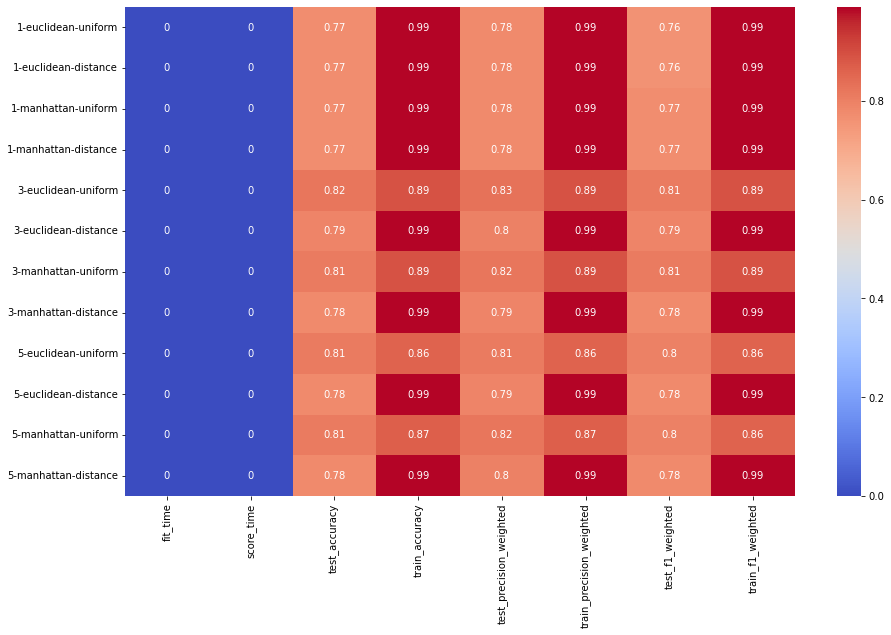

In [11]:
fig1, ax1 = plt.subplots(1, 1 , figsize=(15,9))
full_scores = pds.DataFrame(full_scores)
sns.heatmap(full_scores.T.round(2),annot=True,cmap='coolwarm')
plt.show()

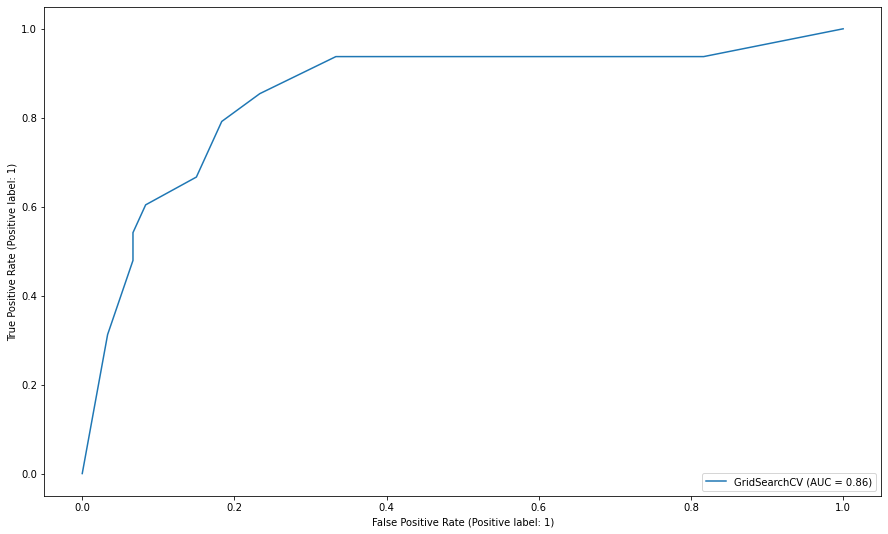

In [12]:
fig, ax = plt.subplots(1, 1 , figsize=(15,9))
rfc_disp = RocCurveDisplay.from_estimator(grid_cv, X_test_z, y_test_z, ax=ax)
plt.show()

In [13]:
knn = KNeighborsClassifier(algorithm= 'ball_tree', n_neighbors= 10, p= 1, weights= 'uniform', metric= 'manhattan')


In [14]:
cv = StratifiedKFold(n_splits=50, random_state=0, shuffle=True)

knn = KNeighborsClassifier(algorithm= 'ball_tree', n_neighbors= 10, p= 1, weights= 'uniform', metric= 'manhattan')
scores_knn = cross_validate(knn, X_train_z, y_train_z, scoring=scoring,cv=cv, return_train_score=True)
scores_knn = pds.DataFrame(scores_knn).mean()

dt = DecisionTreeClassifier(random_state=42, class_weight={0: 0.3, 1: 0.7},max_depth= 3, min_samples_leaf= 1, min_samples_split=2)
scores_dt = cross_validate(dt, X_train, y_train, scoring=scoring,cv=cv, return_train_score=True)
scores_dt = pds.DataFrame(scores_dt).mean()

rdfrst = ensemble.RandomForestClassifier(random_state=42,bootstrap=True, n_estimators= 90, 
                                        min_samples_split= 7, min_samples_leaf= 3, max_depth=15, 
                                        criterion= 'log_loss')
scores_rdfrst = cross_validate(rdfrst, X_train, y_train, scoring=scoring,cv=cv, return_train_score=True)
scores_rdfrst = pds.DataFrame(scores_rdfrst).mean()



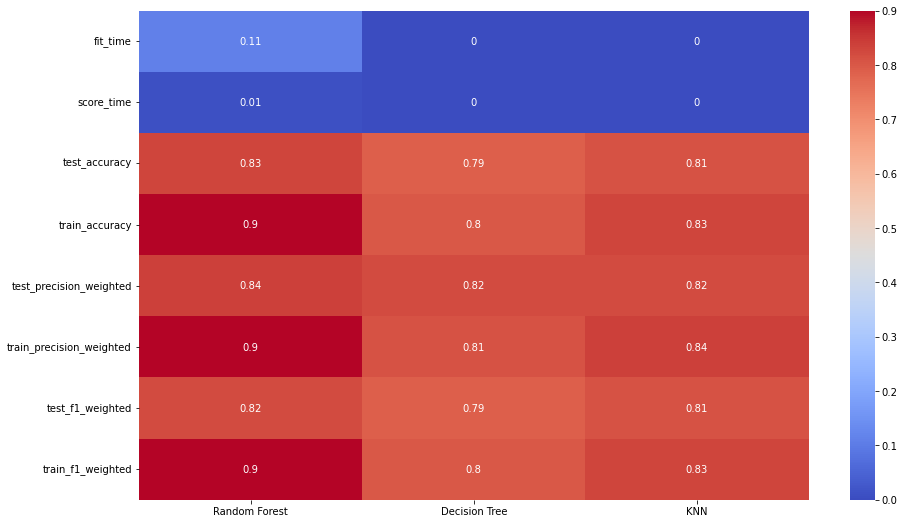

In [15]:
fig, ax = plt.subplots(1, 1 , figsize=(15,9))
full_scores = pds.DataFrame({"Random Forest": scores_rdfrst, "Decision Tree":scores_dt, "KNN":scores_knn})
sns.heatmap(full_scores.T.round(2).T,annot=True,cmap='coolwarm', ax=ax)
plt.show()

In [16]:
knn.fit(X_train_z, y_train_z)

KNeighborsClassifier(algorithm='ball_tree', metric='manhattan', n_neighbors=10,
                     p=1)

In [17]:
# let's use only the sex and Fare
X_vis=copy.deepcopy(X_train_z)
del X_vis["Age"]
del X_vis["Pclass"]
del X_vis["SibSp"]
del X_vis["Parch"]

In [18]:
import warnings


def versiontuple(v):
    return tuple(map(int, (v.split("."))))


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X["Sex"].min() - 1, X["Fare"].max() + 1
    x2_min, x2_max = X["Sex"].min() - 1, X["Fare"].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X["Sex"].loc[[y["Survived"] == cl]], y=X["Fare"].loc[[y["Survived"] == cl]],
                    alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=cl)

In [19]:
plot_decision_regions(X_test_z, y_test_z, knn)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


ValueError: X has 2 features, but KNeighborsClassifier is expecting 6 features as input.